This blog goes over the encoding of the inputs and outputs of Yolo.

This blog assumes that the readers have watched Andrew Ng's Yolo lectures on youtube.
Specifically, the following 4 videos. Each of these videos are (of course free and) about 10 minutes so please watch through all the videos. 

## Andrew Ng's Yolo lecture
- [Neural Networks - Bounding Box Predictions](https://www.youtube.com/watch?v=gKreZOUi-O0&t=0s&index=7&list=PL_IHmaMAvkVxdDOBRg2CbcJBq9SY7ZUvs)
- [C4W3L06 Intersection Over Union](https://www.youtube.com/watch?v=ANIzQ5G-XPE&t=7s)
- [C4W3L07 Nonmax Suppression](https://www.youtube.com/watch?v=VAo84c1hQX8&t=192s)
- [C4W3L08 Anchor Boxes](https://www.youtube.com/watch?v=RTlwl2bv0Tg&t=28s)
- [C4W3L09 YOLO Algorithm](https://www.youtube.com/watch?v=9s_FpMpdYW8&t=34s)


## Reference
- [You Only Look Once:Unified, Real-Time Object Detection](https://arxiv.org/pdf/1506.02640.pdf) 

- [YOLO9000:Better, Faster, Stronger](https://arxiv.org/pdf/1612.08242.pdf)

## Reference in my blog
- [Part 1 Object Detection using YOLOv2 on Pascal VOC2012 - anchor box clustering](https://fairyonice.github.io/Part_1_Object_Detection_with_Yolo_for_VOC_2014_data_anchor_box_clustering.html)

- [Part 2 Object Detection using YOLOv2 on Pascal VOC2012 - input and output encoding](https://fairyonice.github.io/Part%202_Object_Detection_with_Yolo_using_VOC_2014_data_input_and_output_encoding.html)

- [Part 3 Object Detection using YOLOv2 on Pascal VOC2012 - model and loss](https://fairyonice.github.io/Part_3_Object_Detection_with_Yolo_using_VOC_2014_data_model_and_loss.html)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os, cv2

%matplotlib inline

In [2]:
LABELS = ['train',     'horse', 'car',  'chair',       'sofa',
          'aeroplane', 'boat',  'bus',  'pottedplant', 'cow',
          'sheep',     'dog',   'hand', 'bicycle',     'head',
          'bottle',    'cat',   'foot', 'tvmonitor',   'diningtable',
          'motorbike', 'person','bird']


The location where the VOC2012 data is saved.

In [3]:
train_image_folder = "../ObjectDetectionRCNN/VOCdevkit/VOC2012/JPEGImages/"
train_annot_folder = "../ObjectDetectionRCNN/VOCdevkit/VOC2012/Annotations/"

Use the pre-processing code for parsing annotation at [experiencor/keras-yolo2](https://github.com/experiencor/keras-yolo2).
This code is already used in [blahblah]() and saved in my python script. This script can be downloaded at [blahblah]().

In [4]:
import xml.etree.ElementTree as ET
from backend import parse_annotation

## Parse annotations 

In [5]:
train_image, seen_train_labels = parse_annotation(train_annot_folder,
                                                  train_image_folder, 
                                                  labels=LABELS)
print("N train = {}".format(len(train_image)))

N train = 17125


## Input/output encoding
While output encoding of the Yolo is complex, input encoding is pretty simple. 
The input encoding essentialily only requires to readin an image and resize it to the pre-specified shape.

As the first step of output encoding, the output's xmin, ymin, xmax and ymax also need to be resized.

The ImageReader class below does the first step of input and output encoding.


In [6]:
import copy
class ImageReader(object):
    def __init__(self,IMAGE_H,IMAGE_W):
        self.IMAGE_H = IMAGE_H
        self.IMAGE_W = IMAGE_W
        
    def fit(self,train_instance):
        '''
        read in and resize the image, annotations are resized accordingly.
        
        -- Input -- 
        
        train_instance : dictionary containing filename, height, width and object
        
        {'filename': 'ObjectDetectionRCNN/VOCdevkit/VOC2012/JPEGImages/2008_000054.jpg',
         'height':   333,
         'width':    500,
         'object': [{'name': 'bird',
                     'xmax': 318,
                     'xmin': 284,
                     'ymax': 184,
                     'ymin': 100},
                    {'name': 'bird', 
                     'xmax': 198, 
                     'xmin': 112, 
                     'ymax': 209, 
                     'ymin': 146}]
        }
        
        '''
        image_name = train_instance['filename']
        image = cv2.imread(image_name)

        if image is None: print('Cannot find ', image_name)

        h, w, c = image.shape
        all_objs = copy.deepcopy(train_instance['object'])       
            
        # resize the image to standard size
        image = cv2.resize(image, (self.IMAGE_H, self.IMAGE_W))
        image = image[:,:,::-1]

        # fix object's position and size
        for obj in all_objs:
            for attr in ['xmin', 'xmax']:
                obj[attr] = int(obj[attr] * float(self.IMAGE_W) / w)
                obj[attr] = max(min(obj[attr], self.IMAGE_W), 0)
                
            for attr in ['ymin', 'ymax']:
                obj[attr] = int(obj[attr] * float(self.IMAGE_H) / h)
                obj[attr] = max(min(obj[attr], self.IMAGE_H), 0)
                
        return image, all_objs

#### Example useage of InputEncoder

******************************
Input
  object: [{'name': 'person', 'xmin': 174, 'ymin': 101, 'xmax': 349, 'ymax': 351}, {'name': 'head', 'xmin': 169, 'ymin': 104, 'xmax': 209, 'ymax': 146}, {'name': 'hand', 'xmin': 278, 'ymin': 210, 'xmax': 297, 'ymax': 233}, {'name': 'foot', 'xmin': 273, 'ymin': 333, 'xmax': 297, 'ymax': 354}, {'name': 'foot', 'xmin': 319, 'ymin': 307, 'xmax': 340, 'ymax': 326}]
  filename: ../ObjectDetectionRCNN/VOCdevkit/VOC2012/JPEGImages/2007_000027.jpg
  width: 486
  height: 500
******************************
Output
          [{'name': 'person', 'xmin': 150, 'ymin': 84, 'xmax': 300, 'ymax': 294}, {'name': 'head', 'xmin': 145, 'ymin': 87, 'xmax': 180, 'ymax': 122}, {'name': 'hand', 'xmin': 239, 'ymin': 175, 'xmax': 256, 'ymax': 195}, {'name': 'foot', 'xmin': 235, 'ymin': 279, 'xmax': 256, 'ymax': 296}, {'name': 'foot', 'xmin': 275, 'ymin': 257, 'xmax': 293, 'ymax': 273}]


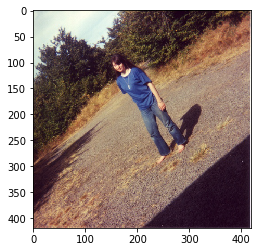

In [7]:
print("*"*30)
print("Input")
timage = train_image[0]
for key, v in timage.items():
    print("  {}: {}".format(key,v))
print("*"*30)
print("Output")
inputEncoder = ImageReader(IMAGE_H=419,IMAGE_W=419)
image, all_objs = inputEncoder.fit(timage)
print("          {}".format(all_objs))
plt.imshow(image)
plt.show()

## Output encoding 1:
### Assign each object to a ground truth anchor box


In [previous blog]() I discussed that anchor box is introduced to detect multiple objects in nearby region (i.e., in the same grid cell), and more over:
- The number of anchor boxes need to be prespecified.

- Each anchor box has its specialized shape, e.g.,
  
  - 1st anchor box specialized small bounding box
  
  - 2nd anchor box specializes narrow bounding box ...
  
- Yolo v2 uses K-means clustering to decide what type of shapes anchor boxes should specialize. See [blahblah]()

- Each object in training image is assigned to grid cell that contains object’s midpoint  and anchor box for the grid cell with highest IoU.

BestAnchorBoxFinder class below find the best anchor box for given candidate anchor boxes.

In [8]:
class BestAnchorBoxFinder(object):
    def __init__(self, ANCHORS):
        '''
        ANCHORS: a np.array of even number length e.g.
        
        _ANCHORS = [4,2, ##  width=4, height=2,  flat large anchor box
                    2,4, ##  width=2, height=4,  tall large anchor box
                    1,1] ##  width=1, height=1,  small anchor box
        '''
        self.anchors = [BoundBox(0, 0, ANCHORS[2*i], ANCHORS[2*i+1]) 
                        for i in range(int(len(ANCHORS)//2))]
        
    def _interval_overlap(self,interval_a, interval_b):
        x1, x2 = interval_a
        x3, x4 = interval_b
        if x3 < x1:
            if x4 < x1:
                return 0
            else:
                return min(x2,x4) - x1
        else:
            if x2 < x3:
                 return 0
            else:
                return min(x2,x4) - x3  

    def bbox_iou(self,box1, box2):
        intersect_w = self._interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
        intersect_h = self._interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])  

        intersect = intersect_w * intersect_h

        w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
        w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin

        union = w1*h1 + w2*h2 - intersect

        return float(intersect) / union
    
    def find(self,center_w, center_h):
        # find the anchor that best predicts this box
        best_anchor = -1
        max_iou     = -1
        # each Anchor box is specialized to have a certain shape.
        # e.g., flat large rectangle, or small square
        shifted_box = BoundBox(0, 0,center_w, center_h)
        ##  For given object, find the best anchor box!
        for i in range(len(self.anchors)): ## run through each anchor box
            anchor = self.anchors[i]
            iou    = self.bbox_iou(shifted_box, anchor)
            if max_iou < iou:
                best_anchor = i
                max_iou     = iou
        return(best_anchor,max_iou)    
    
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax):
        self.xmin, self.ymin = xmin, ymin
        self.xmax, self.ymax = xmax, ymax
    

### Example useage for BestAnchorBoxFinder

In [9]:
_ANCHORS = [4,2, ##  width=4, height=2,  flat large anchor box
            2,4, ##  width=2, height=4,  tall large anchor box
            1,1] ##  width=1, height=1,  small anchor box
print(".."*40)
print("The three example anchor boxes:")
count = 0
for i in range(0,len(_ANCHORS),2):
    print("anchor box index={}, w={}, h={}".format(count,_ANCHORS[i],_ANCHORS[i+1]))
    count += 1
print(".."*40)   
print("Allocate bounding box of various width and height into the three anchor boxes:")  
babf = BestAnchorBoxFinder(_ANCHORS)
for w in range(1,5):
    for h in range(1,5):
        best_anchor,max_iou = babf.find(w,h)
        print("bounding box (w = {}, h = {}) --> best anchor box index = {}, iou = {:03.2f}".format(
            w,h,best_anchor,max_iou))

................................................................................
The three example anchor boxes:
anchor box index=0, w=4, h=2
anchor box index=1, w=2, h=4
anchor box index=2, w=1, h=1
................................................................................
Allocate bounding box of various width and height into the three anchor boxes:
bounding box (w = 1, h = 1) --> best anchor box index = 2, iou = 1.00
bounding box (w = 1, h = 2) --> best anchor box index = 2, iou = 0.50
bounding box (w = 1, h = 3) --> best anchor box index = 1, iou = 0.38
bounding box (w = 1, h = 4) --> best anchor box index = 1, iou = 0.50
bounding box (w = 2, h = 1) --> best anchor box index = 2, iou = 0.50
bounding box (w = 2, h = 2) --> best anchor box index = 0, iou = 0.50
bounding box (w = 2, h = 3) --> best anchor box index = 1, iou = 0.75
bounding box (w = 2, h = 4) --> best anchor box index = 1, iou = 1.00
bounding box (w = 3, h = 1) --> best anchor box index = 0, iou = 0.38
bounding b

## Output encoding 2: 
### Bounding box encoding
The bounding box encoding in [experiencor's code](https://github.com/experiencor/keras-yolo2) is slightly different from what Andrew Ng introduced in his tutorial. First, let's review Andrew's video to understand his encoding:

In [10]:
from IPython.display import IFrame
src = "https://www.youtube.com/embed/6ykvU9WuIws?start=312"
IFrame(src, width=990/2, height=800/2)

In Andrew Ng's youtube tutorial above, the bounding box centers $b_x$ and $b_y$ are defined to range between [0,1] while $b_h$ and $b_w$ are ranging between [0, N grid h) and [0, N grid w). 
However, [experiencor's code](https://github.com/experiencor/keras-yolo2)'s script let $b_x$ and $b_y$ also range between [0, N grid h) and [0, N grid w). 


In [11]:
def rescale_centerxy(obj,config):
    '''
    obj:     dictionary containing xmin, xmax, ymin, ymax
    config : dictionary containing IMAGE_W, GRID_W, IMAGE_H and GRID_H
    '''
    center_x = .5*(obj['xmin'] + obj['xmax'])
    center_x = center_x / (float(config['IMAGE_W']) / config['GRID_W'])
    center_y = .5*(obj['ymin'] + obj['ymax'])
    center_y = center_y / (float(config['IMAGE_H']) / config['GRID_H'])
    return(center_x,center_y)

def rescale_cebterwh(obj,config):
    '''
    obj:     dictionary containing xmin, xmax, ymin, ymax
    config : dictionary containing IMAGE_W, GRID_W, IMAGE_H and GRID_H
    '''    
    # unit: grid cell
    center_w = (obj['xmax'] - obj['xmin']) / (float(config['IMAGE_W']) / config['GRID_W']) 
    # unit: grid cell
    center_h = (obj['ymax'] - obj['ymin']) / (float(config['IMAGE_H']) / config['GRID_H']) 
    return(center_w,center_h)

In [ ]:
## Example comes here

The input encoding is implemented as a part of Batch Generator which is called 

In [12]:
from keras.utils import Sequence

class SimpleBatchGenerator(Sequence):
    def __init__(self, images, config, norm, shuffle=True):
        self.config = config
        self.images = images
        self.norm   = norm
        self.bestAnchorBoxFinder = BestAnchorBoxFinder(config['ANCHORS'])
        self.imageReader = ImageReader(config['IMAGE_H'],config['IMAGE_W'])
        
        if shuffle: 
            np.random.shuffle(self.images)
            
    def __len__(self):
        return int(np.ceil(float(len(self.images))/self.config['BATCH_SIZE']))  
    
    def __getitem__(self, idx):
        l_bound = idx*self.config['BATCH_SIZE']
        r_bound = (idx+1)*self.config['BATCH_SIZE']

        if r_bound > len(self.images):
            r_bound = len(self.images)
            l_bound = r_bound - self.config['BATCH_SIZE']

        instance_count = 0

        x_batch = np.zeros((r_bound - l_bound, self.config['IMAGE_H'], self.config['IMAGE_W'], 3))                         # input images
        b_batch = np.zeros((r_bound - l_bound, 1     , 1     , 1    ,  self.config['TRUE_BOX_BUFFER'], 4))   # list of self.config['TRUE_self.config['BOX']_BUFFER'] GT boxes
        y_batch = np.zeros((r_bound - l_bound, self.config['GRID_H'],  self.config['GRID_W'], self.config['BOX'], 4+1+len(self.config['LABELS'])))                # desired network output

        for train_instance in self.images[l_bound:r_bound]:
            # augment input image and fix object's position and size
            img, all_objs = self.imageReader.fit(train_instance)
            
            # construct output from object's x, y, w, h
            true_box_index = 0
            
            for obj in all_objs:
                if obj['xmax'] > obj['xmin'] and obj['ymax'] > obj['ymin'] and obj['name'] in self.config['LABELS']:
                    center_x, center_y = rescale_centerxy(obj,self.config)
                    
                    grid_x = int(np.floor(center_x))
                    grid_y = int(np.floor(center_y))

                    if grid_x < self.config['GRID_W'] and grid_y < self.config['GRID_H']:
                        obj_indx  = self.config['LABELS'].index(obj['name'])
                        center_w, center_h = rescale_cebterwh(obj,self.config)
                        box = [center_x, center_y, center_w, center_h]
                        best_anchor,max_iou = self.bestAnchorBoxFinder.find(center_w, center_h)
                                
                        # assign ground truth x, y, w, h, confidence and class probs to y_batch
                        # it could happen that the same grid cell contain 2 similar shape objects
                        # as a result the same anchor box is selected as the best anchor box by the multiple objects
                        # in such ase, the object is over written
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 0:4] = box # center_x, center_y, w, h
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 4  ] = 1. # ground truth confidence is 1
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 5+obj_indx] = 1 # class probability of the object
                        
                        # assign the true box to b_batch
                        b_batch[instance_count, 0, 0, 0, true_box_index] = box
                        
                        true_box_index += 1
                        true_box_index = true_box_index % self.config['TRUE_BOX_BUFFER']
                            
            # assign input image to x_batch
            if self.norm != None: 
                x_batch[instance_count] = self.norm(img)
            else:       
                x_batch[instance_count] = img
            # increase instance counter in current batch
            instance_count += 1  
        return [x_batch, b_batch], y_batch

    def on_epoch_end(self):
        if self.shuffle: 
            np.random.shuffle(self.images)



/Users/yumikondo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Experiment with BatchGenerator

In [14]:

GRID_H,  GRID_W  = 13 , 13
BOX              = 5
ANCHORS          = [0.57273, 0.677385, 
                    1.87446, 2.06253, 
                    3.33843, 5.47434, 
                    7.88282, 3.52778, 
                    9.77052, 9.16828]


BATCH_SIZE       = 16
TRUE_BOX_BUFFER  = 50

generator_config = {
    'IMAGE_H'         : IMAGE_H, 
    'IMAGE_W'         : IMAGE_W,
    'GRID_H'          : GRID_H,  
    'GRID_W'          : GRID_W,
    'BOX'             : BOX,
    'LABELS'          : LABELS,
    'CLASS'           : len(LABELS),
    'ANCHORS'         : ANCHORS,
    'BATCH_SIZE'      : BATCH_SIZE,
    'TRUE_BOX_BUFFER' : 50,
}

def normalize(image):
    return image / 255.
train_batch_generator = SimpleBatchGenerator(train_image, generator_config,
                                             norm=normalize, shuffle=True)

[x_batch,b_batch],y_batch = train_batch_generator.__getitem__(idx=3)

In [15]:
print(x_batch.shape,b_batch.shape,y_batch.shape)

(16, 416, 416, 3) (16, 1, 1, 1, 50, 4) (16, 13, 13, 5, 28)


### Check which (grid cell, Anchor box) pair contains objects

In [20]:
irow= 1
def check_object_in_grid_anchor_pair(irow):
    for igrid_h in range(generator_config["GRID_H"]):
        for igrid_w in range(generator_config["GRID_W"]):
            for ianchor in range(generator_config["BOX"]):
                vec = y_batch[irow,igrid_h,igrid_w,ianchor,:]
                C = vec[4] ## ground truth confidence
                if C == 1:
                    class_nm = np.array(LABELS)[np.where(vec[5:])]
                    assert len(class_nm) == 1
                    print("iGRIDH={:02.0f},iGRIDW={:02.0f},iAnchor={:02.0f}, {}".format(
                        igrid_h,igrid_w,ianchor,class_nm[0]))
check_object_in_grid_anchor_pair(irow)

iGRIDH=10,iGRIDW=04,iAnchor=01, chair
iGRIDH=10,iGRIDW=05,iAnchor=01, chair
iGRIDH=10,iGRIDW=06,iAnchor=01, chair
iGRIDH=10,iGRIDW=07,iAnchor=01, chair
iGRIDH=10,iGRIDW=08,iAnchor=01, chair
iGRIDH=10,iGRIDW=09,iAnchor=01, chair
iGRIDH=10,iGRIDW=11,iAnchor=01, chair
iGRIDH=10,iGRIDW=12,iAnchor=01, chair


## Visualize the output of the BatchGenerator

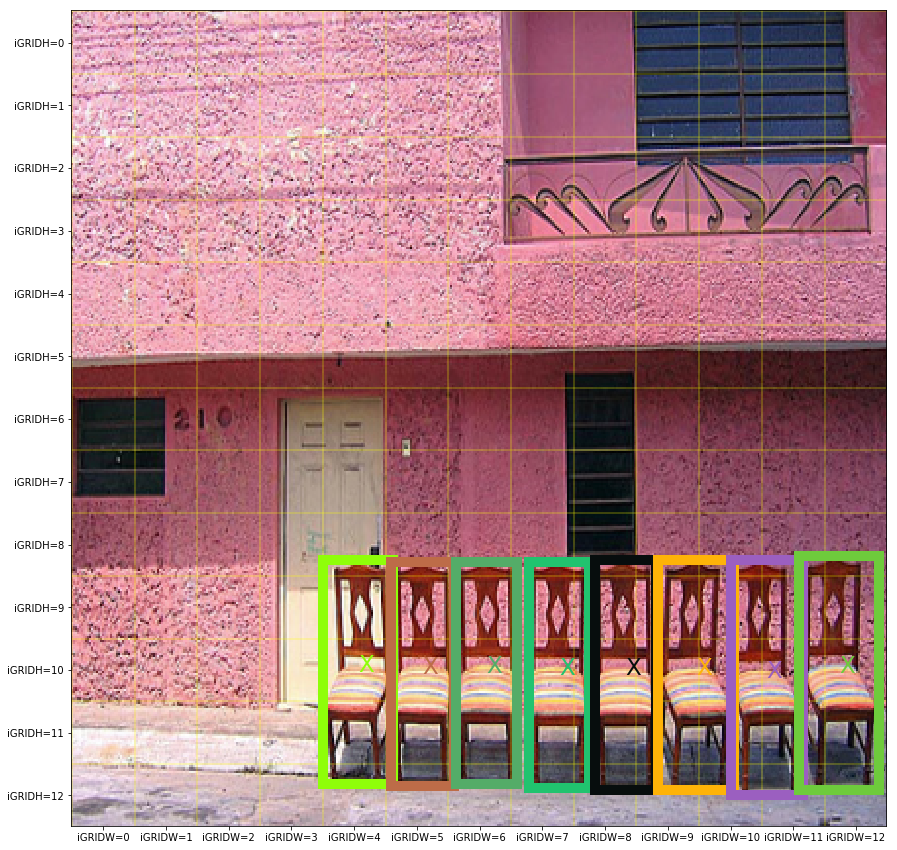

In [21]:


def plot_image_with_grid_cell_partition(irow):
    img = x_batch[irow]
    plt.figure(figsize=(15,15))
    plt.imshow(img)
    for wh in ["W","H"]:
        GRID_       = generator_config["GRID_"  + wh] ## 13
        IMAGE_      = generator_config["IMAGE_" + wh] ## 416
        if wh == "W":
            pltax   = plt.axvline
            plttick = plt.xticks
        else:
            pltax   = plt.axhline
            plttick = plt.yticks
            
        for count in range(GRID_):
            l = IMAGE_*count/GRID_
            pltax(l,color="yellow",alpha=0.3) 
        plttick([(i + 0.5)*IMAGE_/GRID_ for i in range(GRID_)],
                ["iGRID{}={}".format(wh,i) for i in range(GRID_)])

def plot_grid(irow):
    import seaborn as sns
    color_palette = list(sns.xkcd_rgb.values())
    iobj = 0
    for igrid_h in range(generator_config["GRID_H"]):
        for igrid_w in range(generator_config["GRID_W"]):
            for ianchor in range(generator_config["BOX"]):
                vec = y_batch[irow,igrid_h,igrid_w,ianchor,:]
                C = vec[4] ## ground truth confidence
                if C == 1:
                    class_nm = np.array(LABELS)[np.where(vec[5:])]
                    x, y, w, h = vec[:4]
                    multx = generator_config["IMAGE_W"]/generator_config["GRID_W"]
                    multy = generator_config["IMAGE_H"]/generator_config["GRID_H"]
                    c = color_palette[iobj]
                    iobj += 1
                    xmin = x - 0.5*w
                    ymin = y - 0.5*h
                    xmax = x + 0.5*w
                    ymax = y + 0.5*h
                    # center
                    plt.text(x*multx,y*multy,
                             "X",color=c,fontsize=23)
                    plt.plot(np.array([xmin,xmin])*multx,
                             np.array([ymin,ymax])*multy,color=c,linewidth=10)
                    plt.plot(np.array([xmin,xmax])*multx,
                             np.array([ymin,ymin])*multy,color=c,linewidth=10)
                    plt.plot(np.array([xmax,xmax])*multx,
                             np.array([ymax,ymin])*multy,color=c,linewidth=10)  
                    plt.plot(np.array([xmin,xmax])*multx,
                             np.array([ymax,ymax])*multy,color=c,linewidth=10)

plot_image_with_grid_cell_partition(irow)
plot_grid(irow)
plt.show()
                    


------------------------------
iGRIDH=07,iGRIDW=08,iAnchor=04, person


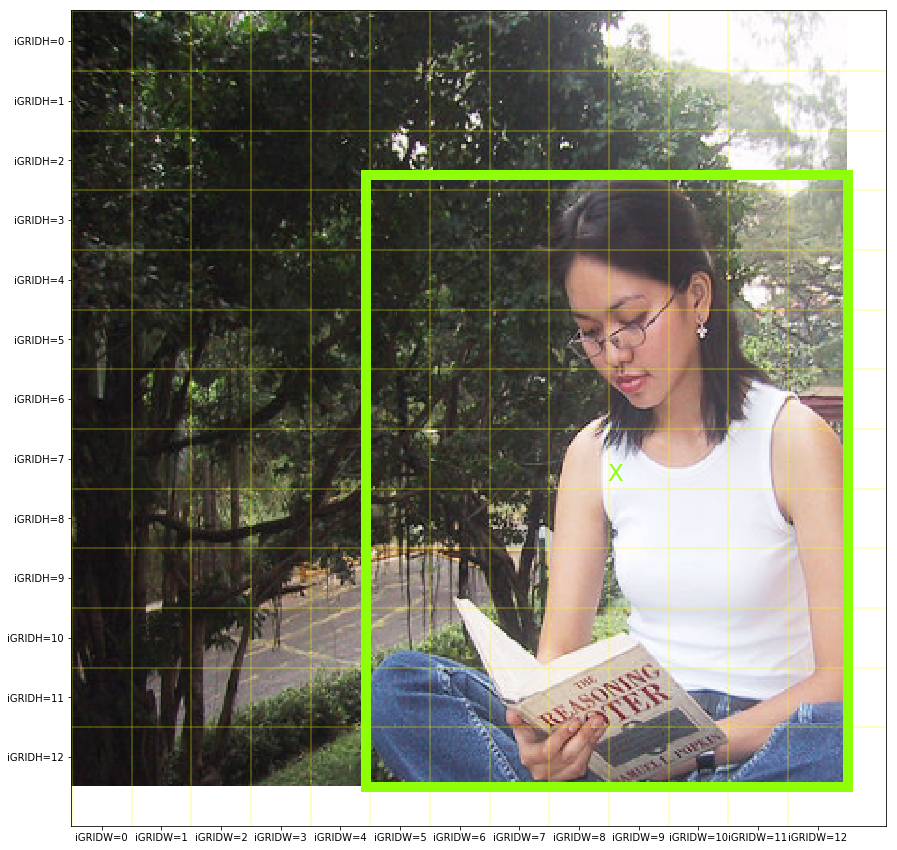

------------------------------
iGRIDH=10,iGRIDW=04,iAnchor=01, chair
iGRIDH=10,iGRIDW=05,iAnchor=01, chair
iGRIDH=10,iGRIDW=06,iAnchor=01, chair
iGRIDH=10,iGRIDW=07,iAnchor=01, chair
iGRIDH=10,iGRIDW=08,iAnchor=01, chair
iGRIDH=10,iGRIDW=09,iAnchor=01, chair
iGRIDH=10,iGRIDW=11,iAnchor=01, chair
iGRIDH=10,iGRIDW=12,iAnchor=01, chair


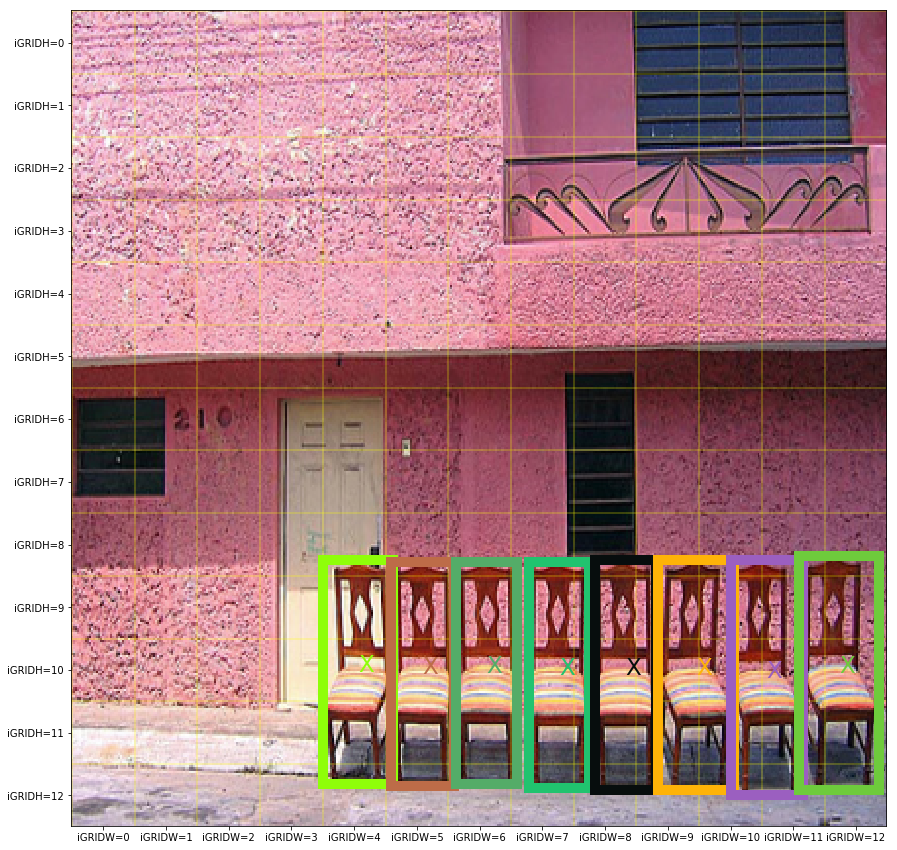

------------------------------
iGRIDH=01,iGRIDW=00,iAnchor=01, person
iGRIDH=02,iGRIDW=04,iAnchor=01, person
iGRIDH=02,iGRIDW=05,iAnchor=02, person
iGRIDH=03,iGRIDW=00,iAnchor=00, person
iGRIDH=04,iGRIDW=12,iAnchor=02, person
iGRIDH=08,iGRIDW=06,iAnchor=02, person
iGRIDH=08,iGRIDW=07,iAnchor=02, person
iGRIDH=08,iGRIDW=09,iAnchor=02, person
iGRIDH=09,iGRIDW=03,iAnchor=02, person
iGRIDH=09,iGRIDW=08,iAnchor=02, person
iGRIDH=09,iGRIDW=09,iAnchor=02, person


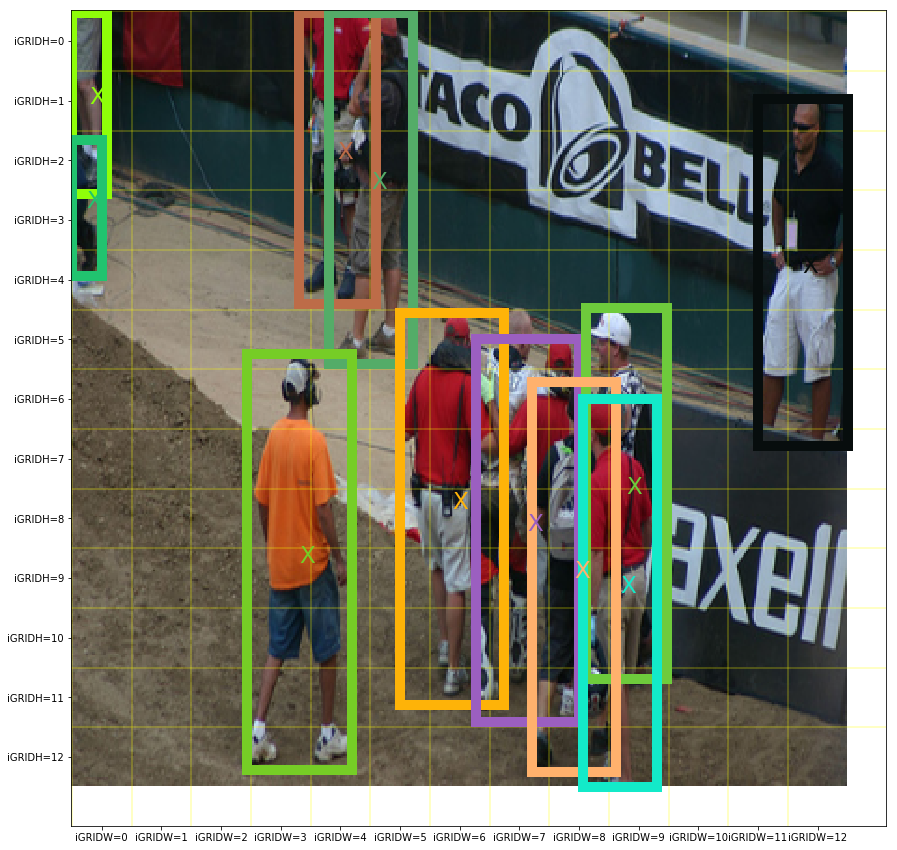

------------------------------
iGRIDH=08,iGRIDW=07,iAnchor=04, sofa


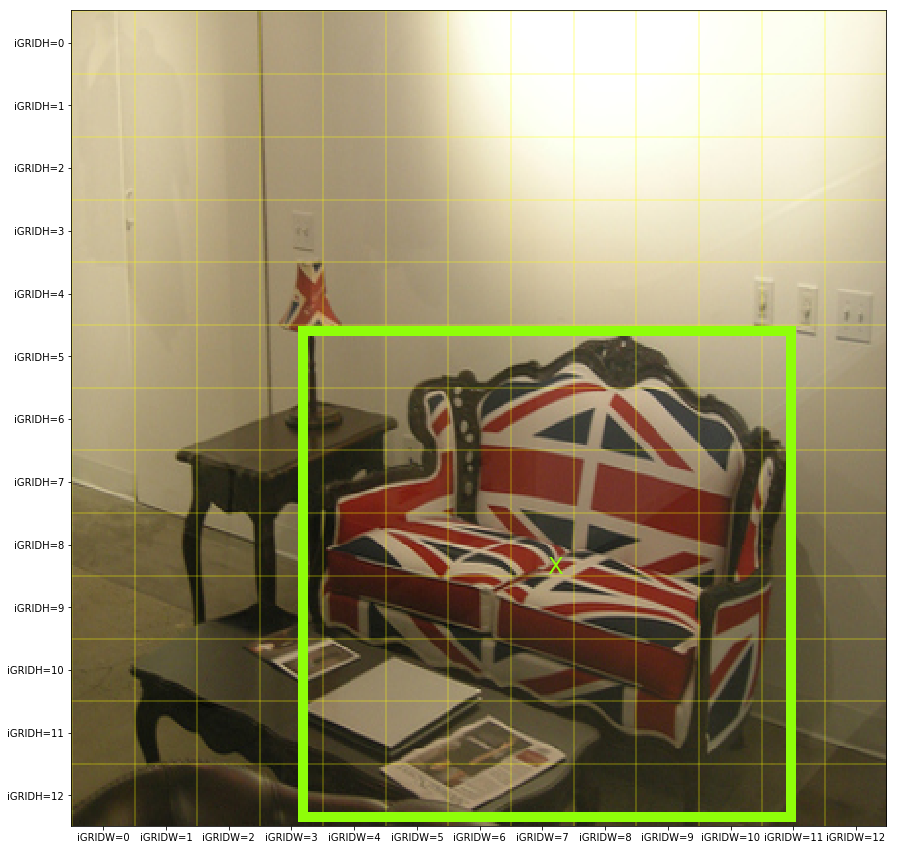

------------------------------
iGRIDH=05,iGRIDW=01,iAnchor=00, pottedplant
iGRIDH=05,iGRIDW=11,iAnchor=01, pottedplant
iGRIDH=06,iGRIDW=10,iAnchor=01, pottedplant
iGRIDH=06,iGRIDW=11,iAnchor=00, pottedplant
iGRIDH=07,iGRIDW=05,iAnchor=01, pottedplant
iGRIDH=07,iGRIDW=06,iAnchor=01, pottedplant
iGRIDH=08,iGRIDW=07,iAnchor=01, pottedplant
iGRIDH=08,iGRIDW=09,iAnchor=01, pottedplant
iGRIDH=08,iGRIDW=10,iAnchor=01, pottedplant
iGRIDH=08,iGRIDW=11,iAnchor=00, pottedplant
iGRIDH=08,iGRIDW=12,iAnchor=01, pottedplant
iGRIDH=09,iGRIDW=00,iAnchor=01, pottedplant
iGRIDH=09,iGRIDW=03,iAnchor=02, person


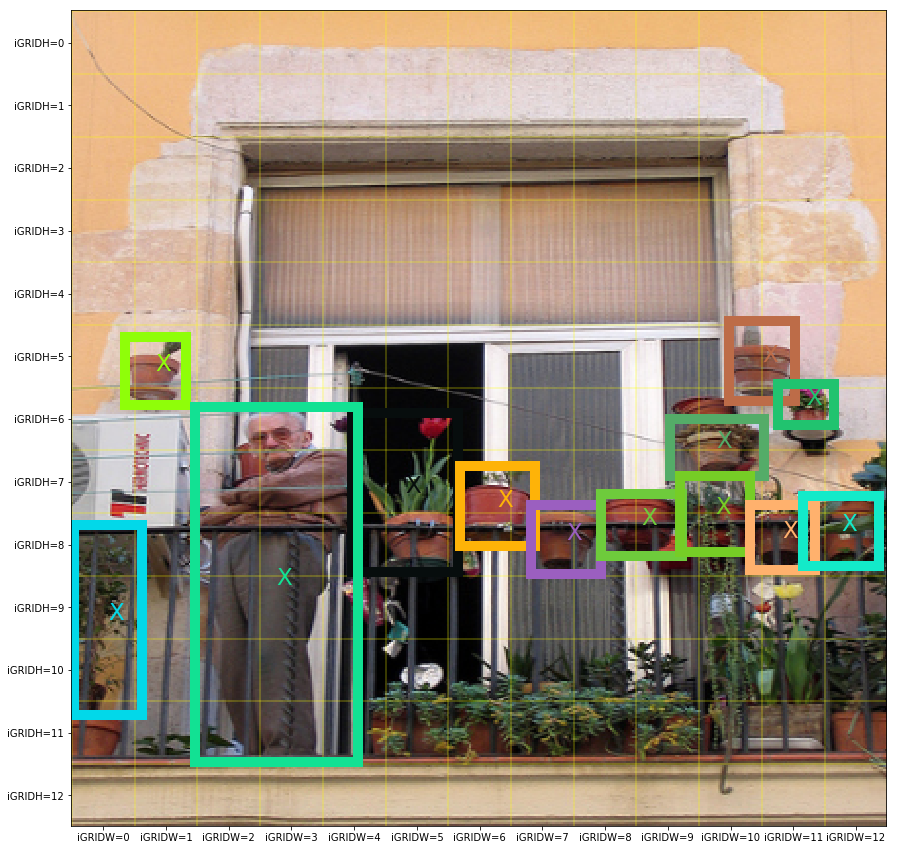

In [23]:
for irow in range(5):
    print("-"*30)
    check_object_in_grid_anchor_pair(irow)
    plot_image_with_grid_cell_partition(irow)
    plot_grid(irow)
    plt.show()
